In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
import re

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [5]:
q = """SELECT payments.npi, 
                doctor_ratings.recommended_by_doctors, 
                doctor_ratings.board_certification, 
                doctor_ratings.graduation_year,
                doctor_ratings.internship_residency, 
                doctor_ratings.confidence, 
                doctor_ratings.name, 
                doctor_ratings.relative_volume,
                payments.hcpcs_code, 
                payments.hcpcs_description,
                payments.bene_day_srvc_cnt,
                payments.average_medicare_standard_amt,
                payments.hcpcs_drug_indicator, 
                payments.place_of_service
        FROM payments
        LEFT JOIN doctor_ratings 
        ON (payments.npi = doctor_ratings.npi)
        WHERE provider_type = 'Orthopedic Surgery'"""
doctors = pd.read_sql_query(q, con=con)

In [6]:
doctors.head()

,npi,recommended_by_doctors,board_certification,graduation_year,internship_residency,confidence,name,relative_volume,hcpcs_code,hcpcs_description,bene_day_srvc_cnt,average_medicare_standard_amt,hcpcs_drug_indicator,place_of_service
0,1003033119,None,None,None,None,NaN,None,None,20605,Aspiration and/or injection of medium joint or...,12.0,38.08,N,O
1,1003033119,None,None,None,None,NaN,None,None,73610,"X-ray of ankle, minimum of 3 views",173.0,26.25,N,O
2,1003033119,None,None,None,None,NaN,None,None,73630,"X-ray of foot, minimum of 3 views",191.0,24.94,N,O
3,1003033119,None,None,None,None,NaN,None,None,99203,"New patient office or other outpatient visit, ...",46.0,77.76,N,O
4,1003033119,None,None,None,None,NaN,None,None,99204,"New patient office or other outpatient visit, ...",48.0,125.43,N,O


In [7]:
by_npi = (doctors.query('place_of_service == "F"')[['npi','hcpcs_code','bene_day_srvc_cnt']].
                pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
                fillna(value=0))

by_npi.head(4)

hcpcs_code,0054T,0055T,0171T,0275T,10140,10180,11011,11012,11042,11043,...,G0414,G0416,G0438,G0439,G0453,G0461,G0462,J1030,J1100,J3301
npi,,,,,,,,,,,,,,,,,,,,,
1003002890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003010919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003012493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003013947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
## create doctors label (0 if not in surgeonratings, 1 if yes)
y = (pd.DataFrame({'npi': by_npi.index}).
     merge(doctors.drop_duplicates(['npi'])[['npi','name']]).
    fillna(value = np.nan))

y.loc[pd.notnull(y.name), 'name'] = 1
y.loc[pd.isnull(y.name), 'name'] = 0
y.head()

,npi,name
0,1003002890,0
1,1003010919,0
2,1003012493,0
3,1003013947,0
4,1003016718,0


In [55]:
## check: how many doctors are in surgeon ratings as well as payments?
y.name.sum()

3310

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve
from sklearn.cross_validation import train_test_split

import time

In [61]:
by_npi.as_matrix().shape

(16320, 856)

In [73]:
ytrue = y.name.as_matrix().astype('int')

## Train and evaluation on whole set

In [70]:
clf = LogisticRegression(random_state=5435)
tic = time.time()
clf.fit(by_npi.as_matrix(), ytrue)
toc = time.time()
print('computed in {}s'.format(toc-tic))

computed in 0.886131763458252s


In [71]:
## how does the model do on the training data?
y_pred = clf.predict(by_npi.as_matrix())

In [74]:
accuracy_score(ytrue, y_pred)

0.82077205882352944

In [75]:
confusion_matrix(ytrue, y_pred)

array([[12514,   496],
       [ 2429,   881]])

In [76]:
precision_recall_fscore_support(ytrue, y_pred)

(array([ 0.83744897,  0.63979666]),
 array([ 0.96187548,  0.26616314]),
 array([ 0.89536007,  0.37593343]),
 array([13010,  3310]))

In [77]:
roc_curve(ytrue, y_pred)

(array([ 0.        ,  0.03812452,  1.        ]),
 array([ 0.        ,  0.26616314,  1.        ]),
 array([2, 1, 0]))

## Cross validation (train - val - test)

In [79]:
from sklearn.linear_model import LogisticRegressionCV

In [86]:
X_train, X_test, y_train, y_test = train_test_split(by_npi.as_matrix(),
                                                    ytrue,
                                                    test_size=.2,
                                                    random_state=5435,
                                                    stratify=ytrue)

In [87]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13056, 856), (3264, 856), (13056,), (3264,))

In [88]:
clf = LogisticRegressionCV(cv = 10, random_state=5435, scoring='roc_auc')
tic = time.time()
clf.fit(X_train, y_train)
toc = time.time()
#print('computed in {}s'.format(toc-tic))

In [90]:
print ('Max auc_roc:', clf.scores_[1].max())

Max auc_roc: 0.83733974359


In [91]:
## how does the model do on the test data?
y_test_pred = clf.predict(X_test)

In [92]:
## accuracy on test set
accuracy_score(y_test, y_test_pred)

0.81219362745098034

In [93]:
## on test set
precision_recall_fscore_support(y_test, y_test_pred)

(array([ 0.83050847,  0.59607843]),
 array([ 0.96041507,  0.22960725]),
 array([ 0.89075031,  0.33151581]),
 array([2602,  662]))

In [94]:
## get test set probabilities to calculate AUC under ROC
y_score = clf.decision_function(X_test)

In [99]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc_test = auc(fpr, tpr)

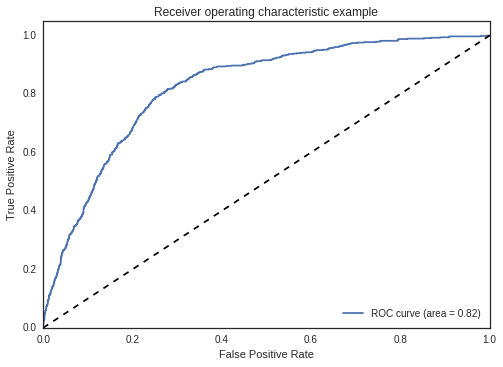

In [100]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [101]:
## get model parameters
clf.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 10,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 5435,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [105]:
## best regularization parameter determined by cross validation
clf.C_

array([ 0.0001])

In [118]:
## coefficients of the features
logistic_reg_coef = clf.coef_.T

In [134]:
## what are the 10 coefficients with the largest positive value?
idxs = np.argsort(logistic_reg_coef.T)

In [133]:
top10_negative_hcpcs_code = by_npi.columns.values[idxs[0,:10]]
top10_positive_hcpcs_code = by_npi.columns.values[idxs[0,-10:]]

In [137]:
list(top10_negative_hcpcs_code)

['27487',
 '63047',
 '22851',
 '27430',
 '63048',
 '28285',
 '29828',
 '22614',
 '27134',
 '26055']

In [139]:
## hcpcs descriptions corresponding to top 10 negative coefficients
(doctors.drop_duplicates('hcpcs_code').
    loc[doctors.hcpcs_code.isin(list(top10_negative_hcpcs_code)),
        ['hcpcs_code','hcpcs_description']])

,hcpcs_code,hcpcs_description
57,22851,Insertion of spinal instrumentation for spinal...
58,63047,Partial removal of middle spine bone with rele...
59,63048,Partial removal of spine bone with release of ...
88,22614,"Fusion of spine bones, posterior or posterolat..."
558,26055,Incision of tendon covering
773,27487,Revision of lower thigh bone and both shin bon...
1963,27134,Revision of thigh bone and hip joint prosthesis
2556,28285,Correction of toe joint deformity
3099,29828,Release of shoulder biceps tendon using an end...
28051,27430,Repair of muscle group above knee joint


In [140]:
## hcpcs descriptions corresponding to top 10 positive coefficients
(doctors.drop_duplicates('hcpcs_code').
    loc[doctors.hcpcs_code.isin(list(top10_positive_hcpcs_code)),
        ['hcpcs_code','hcpcs_description']])

,hcpcs_code,hcpcs_description
72,27447,Repair of knee joint
115,72100,"X-ray of lower and sacral spine, 2 or 3 views"
166,G0180,Physician certification for medicare-covered h...
212,29881,Removal of one knee cartilage using an endoscope
224,73565,"X-ray of both knees, standing, front to back view"
1780,64493,Injections of lower or sacral spine facet join...
2836,G0289,"Arthroscopy, knee, surgical, for removal of lo..."
3198,93922,Ultrasound study of arteries of both arms and ...
15762,97605,"Negative pressure wound therapy, surface area ..."
33799,12032,Repair of wound (2.6 to 7.5 centimeters) of th...
